# [大气光幂雾图像的清晰度复原(2016)](http://www.doc88.com/p-9913150696320.html)

## 需要了解的算法

### Retinex类算法
- 具有迭代思路的Retinex算法（1983）
    - 处理效率高
- 单尺度和多尺度类型的环绕中心的Retinex方法（1997）
    - 更适宜处理雾气分布较为平均的降质图像
- 基于马尔可夫随机场模型的Retinex增强算法
    - 提升算法处理效率和时间

### 直方图匹配方法
- 景深突变处易出现细节信息的丢失

### 暗通道
- He
    - 对景物色彩变化不明显、阴影部分面积小的图像处理效果不佳
    - 算法效率
- 对色度空间实现半逆转换，提高算法的速度和鲁棒性

### 获取大气光幂
- 采用中值滤波
- 易在深度突变处引起晕轮效应，不能保留完整的边缘细节

## 本文方法
本文首先采用[各向异性滤波]()处理大气光幂，然后用色调调整。对全球环境光$A$先采用高通滤波滤取，进而采用循环四分图算法精细化处理。


## 1 全球环境光值$A$的估计

由于全球环境光值$A$接近于图像中雾气最浓处的值，而图像受雾气影响的部分属于低频区，故本文通过滤波操作得到全球环境光值$A$的区间，进而对滤波之后的图像采用[循环四分图算法]()来确定全球大气光值$A$。

### 1.1 高斯低频滤波定位$A$值区间

#### 1.1.1 高斯低通滤波器

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('/work/meteorology/data/competitions/ug2/reside_dahaze_datasets/testset/SOTS/outdoor/gt/0001.png', 0)

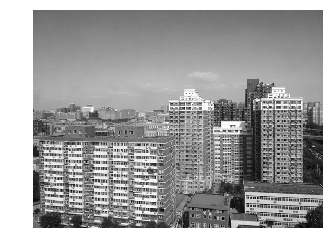

In [3]:
plt.imshow(img,cmap="gray")
plt.axis("off")
plt.show()

In [4]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

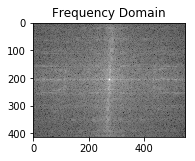

In [5]:
s1 = np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(s1,'gray')
plt.title('Frequency Domain')
plt.show()

In [6]:
def make_transform_matrix(d,image):
    transfor_matrix = np.zeros(image.shape)
    center_point = tuple(map(lambda x:(x-1)/2,s1.shape))
    for i in range(transfor_matrix.shape[0]):
        for j in range(transfor_matrix.shape[1]):
            def cal_distance(pa,pb):
                from math import sqrt
                dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                return dis
            dis = cal_distance(center_point,(i,j))
            if dis <= d:
                transfor_matrix[i,j]=1
            else:
                transfor_matrix[i,j]=0
    return transfor_matrix

d_1 = make_transform_matrix(10,fshift)
d_2 = make_transform_matrix(30,fshift)
d_3 = make_transform_matrix(50,fshift)

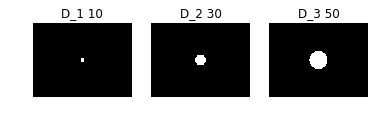

In [7]:
plt.subplot(131)
plt.axis("off")
plt.imshow(d_1,cmap="gray")
plt.title('D_1 10')
plt.subplot(132)
plt.axis("off")
plt.title('D_2 30')
plt.imshow(d_2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D_3 50")
plt.imshow(d_3,cmap="gray")
plt.show()

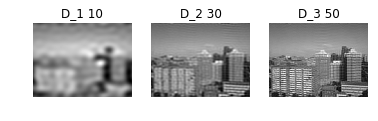

In [8]:
img_d1 = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_1)))
img_d2 = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_2)))
img_d3 = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_3)))
plt.subplot(131)
plt.axis("off")
plt.imshow(img_d1,cmap="gray")
plt.title('D_1 10')
plt.subplot(132)
plt.axis("off")
plt.title('D_2 30')
plt.imshow(img_d2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D_3 50")
plt.imshow(img_d3,cmap="gray")
plt.show()

In [9]:
def lowPassFilter(image,d):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    
    def make_transform_matrix(d):
        transfor_matrix = np.zeros(image.shape)
        center_point = tuple(map(lambda x:(x-1)/2,s1.shape))
        for i in range(transfor_matrix.shape[0]):
            for j in range(transfor_matrix.shape[1]):
                def cal_distance(pa,pb):
                    from math import sqrt
                    dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                    return dis
                dis = cal_distance(center_point,(i,j))
                if dis <= d:
                    transfor_matrix[i,j]=1
                else:
                    transfor_matrix[i,j]=0
        return transfor_matrix
    d_matrix = make_transform_matrix(d)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_matrix)))
    return new_img

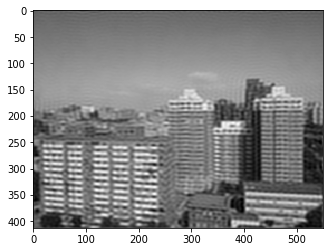

In [10]:
plt.imshow(lowPassFilter(img,60),cmap="gray")

In [11]:
# 高斯低通滤波器
def GaussianLowFilter(image,d):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    def make_transform_matrix(d):
        transfor_matrix = np.zeros(image.shape)
        center_point = tuple(map(lambda x:(x-1)/2,s1.shape))
        for i in range(transfor_matrix.shape[0]):
            for j in range(transfor_matrix.shape[1]):
                def cal_distance(pa,pb):
                    from math import sqrt
                    dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                    return dis
                dis = cal_distance(center_point,(i,j))
                transfor_matrix[i,j] = np.exp(-(dis**2)/(2*(d**2)))
        return transfor_matrix
    d_matrix = make_transform_matrix(d)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_matrix)))
    return new_img

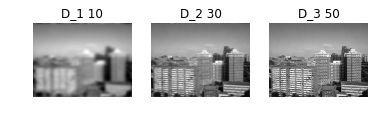

In [12]:
img_d1 = GaussianLowFilter(img,10)
img_d2 = GaussianLowFilter(img,30)
img_d3 = GaussianLowFilter(img,50)
plt.subplot(131)
plt.axis("off")
plt.imshow(img_d1,cmap="gray")
plt.title('D_1 10')
plt.subplot(132)
plt.axis("off")
plt.title('D_2 30')
plt.imshow(img_d2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D_3 50")
plt.imshow(img_d3,cmap="gray")
plt.show()

### 1.2 循环四分图算法确定全球环境光值A